### This notebook implements Omnifold using a decision tree classifier
#### Fake MC data, simulation data, and measured data is used to test this
#### The results are directly compared to IBU from RooUnfold

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import data_handler as dh
from omnifold import binned_omnifold, unbinned_omnifold
import mplhep as hep
hep.style.use(hep.style.CMS)

### Creating datasets

In [2]:
# There are two different smearing functions that we consider when generating data
# These are taken from the RooUnfold tutorials (github.com/vincecr0ft/RooUnfoldTutorials)
# The two datasets use different binning
smearing_function = "smear"
if smearing_function == "calo":
    sim_bins  = 40
    MC_bins   = 40
    sim_low   = 0
    sim_high  = 10
    MC_low    = 0
    MC_high   = 10
else:
    sim_bins  = 40
    MC_bins   = 40
    sim_low   = -10
    sim_high  = 10
    MC_low    = -10
    MC_high   = 10

In [3]:
MC_hist  = ROOT.TH1D("MC_hist", "MC_hist", MC_bins, MC_low, MC_high)
sim_hist = ROOT.TH1D("sim_hist", "sim_hist", sim_bins, sim_low, sim_high)
response = ROOT.RooUnfoldResponse(sim_bins, sim_low, sim_high, MC_bins, MC_low, MC_high)

In [4]:
num_MC_data_points  = 100000
unbinned_sim_data = []
unbinned_MC_data  = []

In [5]:
for i in range(num_MC_data_points):
  # Generating MC data
  if smearing_function == "calo":
      xt = ROOT.gRandom.BreitWigner(5.0, 1.0)
  else:
      xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  MC_hist.Fill(xt)
  # Smearing the MC data
  x = dh.smearing_wrapper(xt, smearing_function)
  fill_MC = False
  if xt > MC_low and xt < MC_high:
      unbinned_MC_data.append(xt)
      fill_MC = True
  if x!=None:
    response.Fill(x, xt)
    sim_hist.Fill(x)
    if x > sim_low and x < sim_high:
        if not fill_MC:
            unbinned_MC_data.append(np.nan)
        unbinned_sim_data.append(x)
    else:
        if fill_MC:
            unbinned_sim_data.append(np.nan)
  else:
    response.Miss(xt)
    if fill_MC:
        unbinned_sim_data.append(np.nan)

unbinned_sim_data = np.array(unbinned_sim_data, dtype=np.float32)
unbinned_MC_data = np.array(unbinned_MC_data, dtype=np.float32)

In [6]:
# Generating true and measured data
unbinned_true_data     = []
unbinned_measured_data = []

true_hist     = ROOT.TH1D ("true_hist", "true_hist", MC_bins, MC_low, MC_high)
measured_hist = ROOT.TH1D ("measured_hist", "measured_hist", sim_bins, sim_low, sim_high)

for i in range(int(num_MC_data_points/10)):
    if smearing_function == "calo":
        xt = ROOT.gRandom.Gaus (5.0, 1.0)
    else:
        xt = ROOT.gRandom.Gaus (0.0, 2.0)
    x = dh.smearing_wrapper(xt, smearing_function)
    true_hist.Fill(xt)
    unbinned_true_data.append(xt)
    if x != None:
        measured_hist.Fill(x);
        unbinned_measured_data.append(x)
    
unbinned_true_data = np.array(unbinned_true_data, dtype=np.float32)
unbinned_measured_data = np.array(unbinned_measured_data, dtype=np.float32)

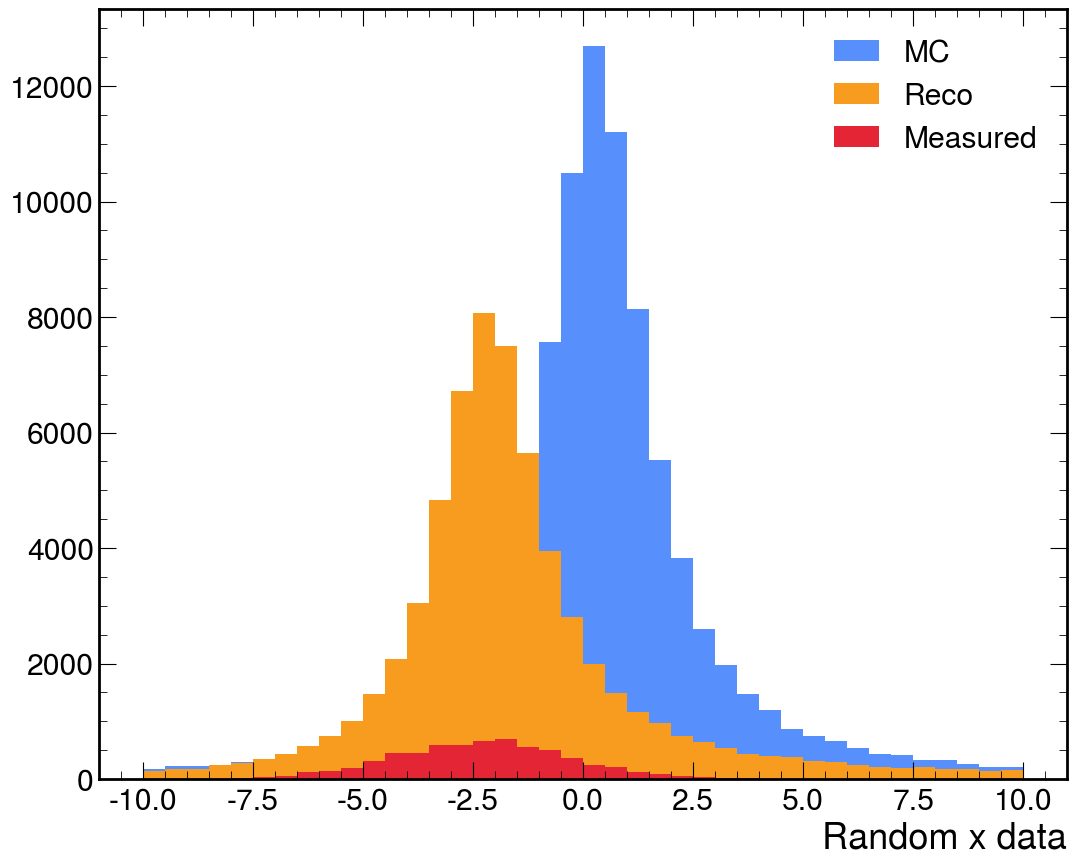

In [7]:
fig = plt.figure(figsize=(12.5,10))
plt.hist(unbinned_MC_data, bins = MC_bins, range=(MC_low, MC_high), label = "MC", histtype='stepfilled')
plt.hist(unbinned_sim_data, bins = sim_bins, range=(sim_low, sim_high), label = "Reco", histtype='stepfilled')
plt.hist(unbinned_measured_data, bins = sim_bins, range=(sim_low, sim_high), label = "Measured", histtype='stepfilled')
plt.legend()
plt.xlabel("Random x data")
fig.savefig('./generated_data.pdf')

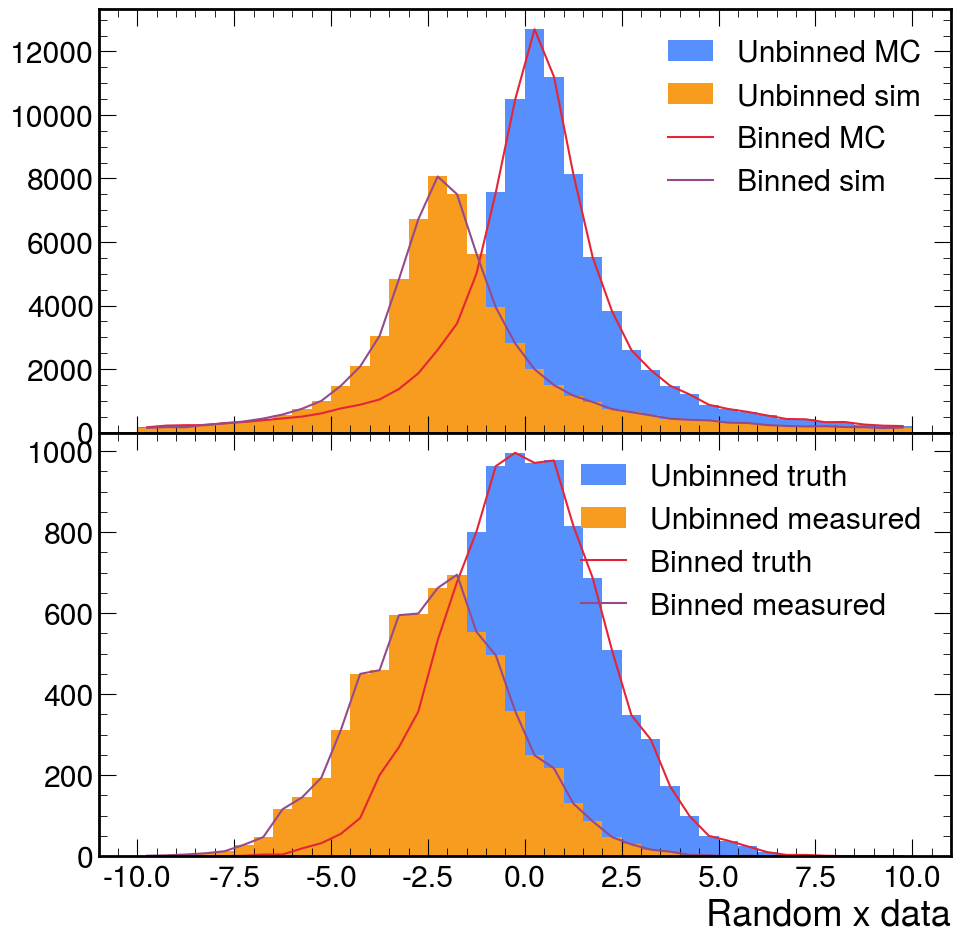

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(11,11), sharex=True)
axs[0].hist(unbinned_MC_data, bins = MC_bins, range=(MC_low, MC_high), label = "Unbinned MC")
axs[0].hist(unbinned_sim_data, bins = sim_bins, range=(sim_low, sim_high), label = "Unbinned sim")
MC_counts, MC_bin_centers = dh.TH1_to_numpy(MC_hist)
axs[0].plot(MC_bin_centers, MC_counts, label = "Binned MC")
sim_counts, sim_bin_centers = dh.TH1_to_numpy(sim_hist)
axs[0].plot(sim_bin_centers, sim_counts, label = "Binned sim")
axs[0].legend()

axs[1].hist(unbinned_true_data, bins = MC_bins, range=(MC_low, MC_high), label = "Unbinned truth")
axs[1].hist(unbinned_measured_data, bins = sim_bins, range=(sim_low, sim_high), label = "Unbinned measured")
truth_counts, truth_bin_centers = dh.TH1_to_numpy(true_hist)
axs[1].plot(truth_bin_centers, truth_counts, label = "Binned truth")
measured_counts, measured_bin_centers = dh.TH1_to_numpy(measured_hist)
axs[1].plot(measured_bin_centers, measured_counts, label = "Binned measured")
axs[1].legend()
axs[1].set_xlabel("Random x data")
plt.subplots_adjust(wspace=0, hspace=0)

### Unfolding procedure

In [9]:
num_iterations = 4

### Binned unfolding using decision trees

In [10]:
# Getting weights from omnifold
binned_weights, MC_entries, _ = binned_omnifold(response, measured_hist, num_iterations)
# Applying weights to MC data
omnifold_MC_hist_binned, omnifold_MC_bin_edges_binned = np.histogram(MC_entries.flatten(), weights = binned_weights[-1][1], bins = MC_bins, range = [MC_low, MC_high])
omnifold_MC_bin_centers_binned = (omnifold_MC_bin_edges_binned[:-1] + omnifold_MC_bin_edges_binned[1:]) / 2

# Accounting for efficiencies
efficiencies = response.Vefficiency()
efficiencies_np = np.empty(efficiencies.GetNoElements())
for i in range(efficiencies.GetNoElements()):
    efficiencies_np[i] = efficiencies[i]
omnifold_MC_hist_binned = np.divide(omnifold_MC_hist_binned, efficiencies_np, out=np.zeros_like(omnifold_MC_hist_binned, dtype=np.float32), where=efficiencies_np!=0)

Iteration 1, Step 1 Test Accuracy: 1.0
Iteration 1, Step 2 Test Accuracy: 1.0
Iteration 2, Step 1 Test Accuracy: 0.6820203092851929
Iteration 2, Step 2 Test Accuracy: 1.0
Iteration 3, Step 1 Test Accuracy: 0.6367890090927192
Iteration 3, Step 2 Test Accuracy: 1.0
Iteration 4, Step 1 Test Accuracy: 0.6240127430809053
Iteration 4, Step 2 Test Accuracy: 1.0


### Unbinned unfolding using decision trees

In [11]:
# Getting weights from omnifold
unbinned_weights, MC_entries_unbinned, sim_entries_unbinned = unbinned_omnifold(unbinned_MC_data, unbinned_sim_data, unbinned_measured_data, num_iterations)

Iteration 1, Step 1 Test Accuracy: 0.9998672595739032
Iteration 1, Step 2 Test Accuracy: 1.0
Iteration 2, Step 1 Test Accuracy: 0.47544302117209797
Iteration 2, Step 2 Test Accuracy: 1.0
Iteration 3, Step 1 Test Accuracy: 0.32342204818477466
Iteration 3, Step 2 Test Accuracy: 1.0
Iteration 4, Step 1 Test Accuracy: 0.25997212451051965
Iteration 4, Step 2 Test Accuracy: 1.0


Text(0.5, 0.98, 'Iteration 4')

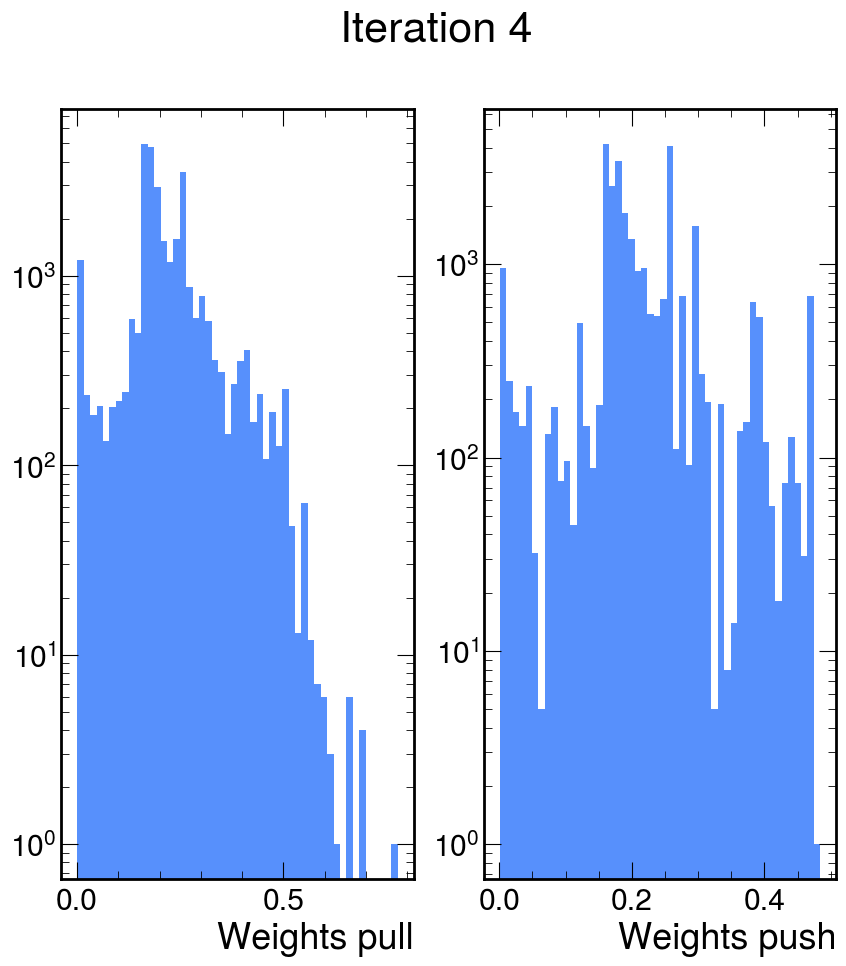

In [12]:
fig, axs = plt.subplots(1, 2)
iteration_to_plot = num_iterations-1
axs[0].hist(unbinned_weights[iteration_to_plot, 0], bins = 50)
axs[0].set_xlabel("Weights pull")
axs[0].set_yscale('log')

axs[1].hist(unbinned_weights[iteration_to_plot, 1], bins = 50)
axs[1].set_xlabel("Weights push")
axs[1].set_yscale('log')
fig.suptitle(f"Iteration {iteration_to_plot+1}")

Text(0.5, 0.98, 'Iteration 4')

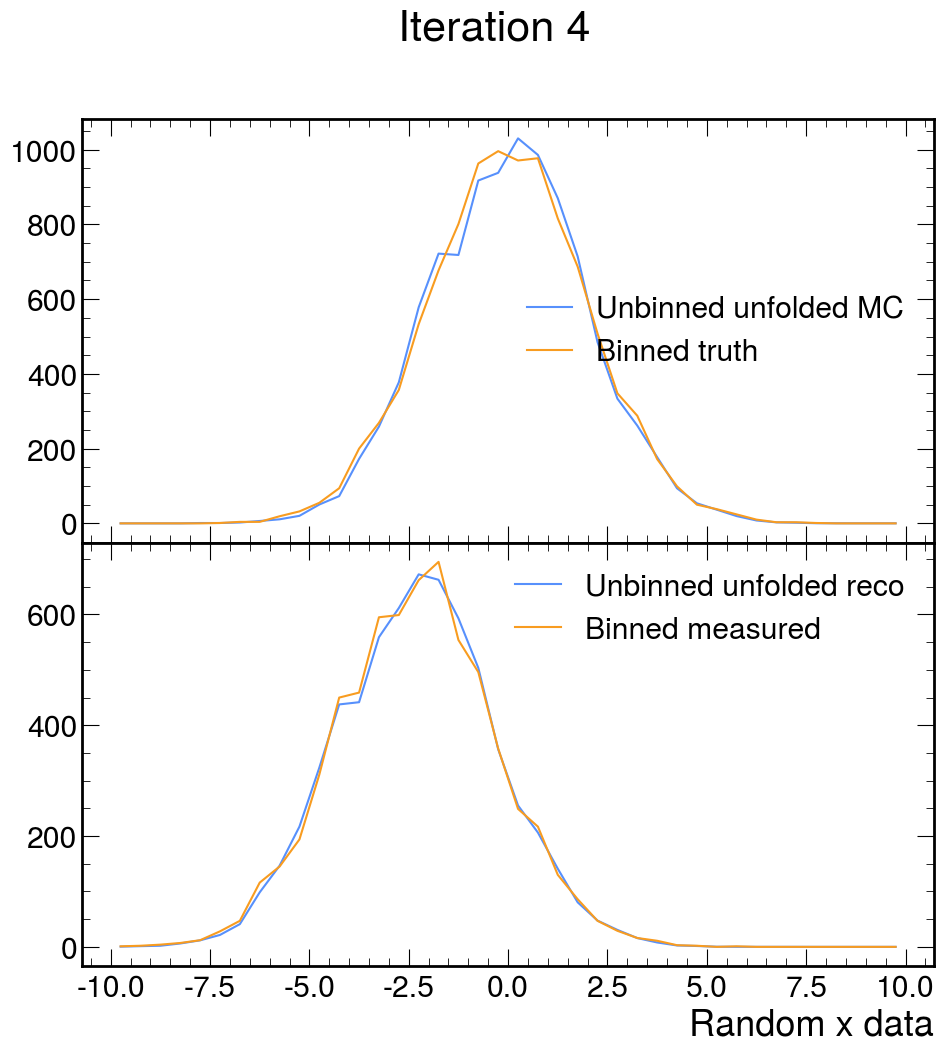

In [13]:
# Inspecting the unbinned unfolded results for sim and MC
omnifold_MC_hist_unbinned, omnifold_MC_bin_edges_unbinned = np.histogram(MC_entries_unbinned.flatten(), weights = unbinned_weights[iteration_to_plot, 1], bins = MC_bins, range = [MC_low, MC_high])
omnifold_MC_bin_centers_unbinned = (omnifold_MC_bin_edges_unbinned[:-1] + omnifold_MC_bin_edges_unbinned[1:]) / 2

# Accounting for efficiencies
omnifold_MC_hist_unbinned = np.divide(omnifold_MC_hist_unbinned, efficiencies_np, out=np.zeros_like(omnifold_MC_hist_unbinned, dtype=np.float32), where=efficiencies_np!=0)

omnifold_sim_hist_unbinned, omnifold_sim_bin_edges_unbinned = np.histogram(sim_entries_unbinned.flatten(), weights = unbinned_weights[iteration_to_plot, 0], bins = sim_bins, range = [sim_low, sim_high])

omnifold_sim_bin_centers_unbinned = (omnifold_sim_bin_edges_unbinned[:-1] + omnifold_sim_bin_edges_unbinned[1:]) / 2

fig, axs = plt.subplots(2, 1, figsize=(11,11), sharex=True)
axs[0].plot(omnifold_MC_bin_centers_unbinned, omnifold_MC_hist_unbinned, label = "Unbinned unfolded MC")
truth_counts, truth_bin_centers = dh.TH1_to_numpy(true_hist)
axs[0].plot(truth_bin_centers, truth_counts, label = "Binned truth")
axs[0].legend()

axs[1].plot(omnifold_sim_bin_centers_unbinned, omnifold_sim_hist_unbinned, label = "Unbinned unfolded reco")
measured_counts, measured_bin_centers = dh.TH1_to_numpy(measured_hist)
axs[1].plot(measured_bin_centers, measured_counts, label = "Binned measured")

axs[1].legend()
axs[1].set_xlabel("Random x data")

plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle(f"Iteration {iteration_to_plot+1}")

In [14]:
# Getting IBU results from RooUnfold
IBU_RooUnfold = ROOT.RooUnfoldBayes(response, measured_hist, num_iterations)
hReco_RooUnfold = IBU_RooUnfold.Hunfold()

Using response matrix priors
Priors:

Vector (40)  is as follows

     |        1  |
------------------
   0 |0.00182442 
   1 |0.00239998 
   2 |0.00254116 
   3 |0.00255202 
   4 |0.00327961 
   5 |0.00362712 
   6 |0.00423526 
   7 |0.00485426 
   8 |0.00548412 
   9 |0.00658095 
  10 |0.00825333 
  11 |0.00953477 
  12 |0.0113158 
  13 |0.0149103 
  14 |0.0202641 
  15 |0.0282785 
  16 |0.0373029 
  17 |0.0542874 
  18 |0.082099 
  19 |0.113874 
  20 |0.137874 
  21 |0.121704 
  22 |0.088441 
  23 |0.059967 
  24 |0.0414947 
  25 |0.0282025 
  26 |0.0214044 
  27 |0.0160071 
  28 |0.013075 
  29 |0.00951305 
  30 |0.00807958 
  31 |0.00709135 
  32 |0.00586421 
  33 |0.00466965 
  34 |0.00455019 
  35 |0.00356197 
  36 |0.00362712 
  37 |0.00276921 
  38 |0.0023674 
  39 |0.00223709 

Now unfolding...
Iteration : 0
Chi^2 of change 970.321
Iteration : 1
Chi^2 of change 7.84678
Iteration : 2
Chi^2 of change 1.56566
Iteration : 3
Chi^2 of change 0.843821
Calculating covariances due to

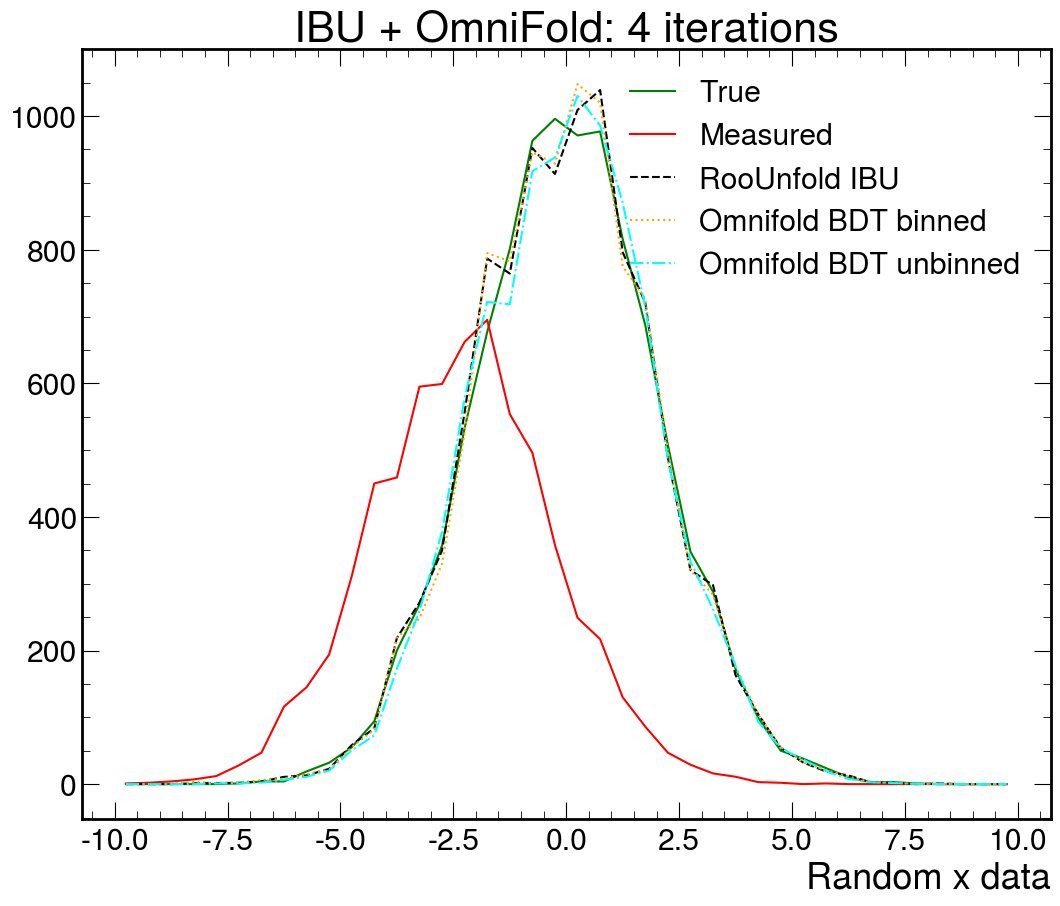

In [15]:
# Plotting our unfolded results
true_data, true_x = dh.TH1_to_numpy(true_hist)
roounfold_data, roounfold_x = dh.TH1_to_numpy(hReco_RooUnfold)
measured_data, measured_x = dh.TH1_to_numpy(measured_hist)

fig = plt.figure(figsize=(12.5,10))
plt.plot(true_x, true_data, label = "True", color = 'green', alpha = 1)
plt.plot(measured_x, measured_data, label = "Measured", color = 'red', alpha = 1)

plt.plot(roounfold_x, roounfold_data, label = "RooUnfold IBU", color = 'black', linestyle='dashed', alpha = 1)
plt.plot(omnifold_MC_bin_centers_binned, omnifold_MC_hist_binned, label = "Omnifold BDT binned", linestyle='dotted', alpha = 1, color = 'orange')

plt.plot(omnifold_MC_bin_centers_unbinned, omnifold_MC_hist_unbinned, label = "Omnifold BDT unbinned", linestyle='dashdot', alpha = 1, color = 'cyan')

plt.xlabel("Random x data")
plt.title(f"IBU + OmniFold: {num_iterations} iterations")
plt.legend()
plt.show()
fig.savefig('./unfolding_output.pdf')